In [131]:
import pickle
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
import random 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
import hdbscan
from itertools import combinations
import umap
import seaborn as sns
from tqdm import tqdm
import torch
import clip
from sklearn.ensemble import IsolationForest

from functions import *

In [3]:
data_dir = os.path.join("../../data/embeddings/")
lsoas_file = os.path.join("../../data/SpatialData/", "LSOAs_2021", "LSOA_2021_EW_BSC_V4.shp")

## Embeddings 
### Get embeddings (four per location)

In [8]:
points_data_cache = data_dir + "sample_points_cache/points_data_cache_with_embeddings_and_attn_stats_new.pkl"
with open(points_data_cache, "rb") as f:
    point_records = pickle.load(f)

### Join image embeddings points to gentrification LSOAs

In [129]:
point_coords = [Point(rec['longitude'], rec['latitude']) for rec in point_records]
points_labels_gdf = gpd.GeoDataFrame(point_records, geometry=point_coords, crs="EPSG:4326")

### Expand so there is one row per each image

In [130]:
expanded_rows = []

for _, row in points_labels_gdf.iterrows():
    embeddings = row['embeddings']      # list of 4 embeddings
    images = row['image_files']        # list of 4 image paths

    # Skip if lengths don't match
    if len(embeddings) != len(images):
        print(f"Skipping row {row.name}: {len(embeddings)} embeddings, {len(images)} images")
        continue

    for emb, img in zip(embeddings, images):
        new_row = row.to_dict()        # copy all other columns
        new_row['embeddings'] = emb     # single embedding
        new_row['image_files'] = img    # single image
        expanded_rows.append(new_row)

# Create new DataFrame
expanded_gdf = pd.DataFrame(expanded_rows)
print(f"Original rows: {len(points_labels_gdf)}, Expanded rows: {len(expanded_gdf)}")
expanded_gdf = pd.DataFrame(expanded_rows)


Skipping row 9158: 3 embeddings, 4 images
Skipping row 12091: 3 embeddings, 4 images
Skipping row 18664: 3 embeddings, 4 images
Original rows: 18897, Expanded rows: 75576


In [135]:
all_embeddings = np.stack(expanded_gdf_trimmed['embeddings'].values)

## Find 'outlying' images

In [134]:
# 1. HDBSCAN outlier scores
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=2,
    metric='euclidean'
).fit(all_embeddings)

scores = clusterer.outlier_scores_
hdb_outliers = scores > np.percentile(scores, 99)

# 2. Isolation Forest
iso = IsolationForest(contamination=0.01).fit(X)
iso_outliers = iso.predict(X) == -1

# 3. Combined decision
final_outliers = np.where(hdb_outliers & iso_outliers)[0]


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


# Find inside images

In [ ]:
def score_image_refined(img_path):
    """
    Returns probabilities for four categories:
    0: true indoor
    1: building exterior
    2: tunnel
    3: other outdoors
    """
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0).to(device)
    except:
        return None  # unreadable

    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text_tokens)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)  # softmax over categories

    return sims[0].cpu().numpy()  # array([indoor, exterior, tunnel, outdoors])

def plot_images_with_scores(image_paths, category_probs, n_cols=5, sort_by="indoor"):
    """
    Plots images in a grid with their category probabilities.
    
    Parameters
    ----------
    image_paths : list of str
        Paths to images
    category_probs : np.array
        Shape (n_images, 4), probabilities for [indoor, exterior, tunnel, outdoors]
    n_cols : int
        Number of columns in the grid
    sort_by : str
        Which category to sort by: 'indoor', 'exterior', 'tunnel', 'outdoors'
    """
    category_map = {"indoor":0, "exterior":1, "tunnel":2, "outdoors":3}
    sort_idx = np.argsort(category_probs[:, category_map[sort_by]])[::-1]
    
    sorted_paths = [image_paths[i] for i in sort_idx]
    sorted_probs = category_probs[sort_idx]
    
    n_images = len(sorted_paths)
    n_rows = math.ceil(n_images / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    axs = axs.flatten()
    
    for i in range(n_images):
        try:
            path = sorted_paths[i]
            adj_path = path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
            img = Image.open(adj_path)
            axs[i].imshow(img)
        except:
            axs[i].axis('off')
            continue
        
        scores_text = "\n".join([
            f"Indoor: {sorted_probs[i,0]:.2f}",
            f"Exterior: {sorted_probs[i,1]:.2f}",
            f"Tunnel: {sorted_probs[i,2]:.2f}",
            f"Outdoors: {sorted_probs[i,3]:.2f}"
        ])
        axs[i].set_title(scores_text, fontsize=8)
        axs[i].axis('off')
    
    # Turn off any remaining axes
    for j in range(n_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [119]:
# ---- Load CLIP ----
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ---- Define prompts ----
prompts = [
    "inside a building, e.g. a house, room, or shop",  # true indoor
    "outside building exterior, façade, wall",         # building exterior
    "inside a tunnel",                                 # tunnels
    "outdoors, open space, streets, roads, highways"  # other outdoors
]
text_tokens = clip.tokenize(prompts).to(device)


# ---- Example: process all images ----
# n_images = 100  # adjust as needed
# category_probs = []
# image_paths_adj = []

for img_path in tqdm(expanded_gdf['image_files'][:len(expanded_gdf)], desc="Processing images"):
#     result = score_image_refined(img_path)
#     if result is None:
#         continue
#     category_probs.append(result)
    image_paths_adj.append(img_path)

category_probs = np.array(category_probs)
true_indoor_scores = category_probs[:,0]
building_exterior_scores = category_probs[:,1]
tunnel_scores = category_probs[:,2]
outdoor_scores = category_probs[:,3]

# ---- Sort by true indoor score ----
sorted_idx = np.argsort(true_indoor_scores)[::-1]
sorted_scores = true_indoor_scores[sorted_idx]
sorted_paths = [image_paths_adj[i] for i in sorted_idx]

print(f"Number of true indoor images (score>0.7): {np.sum(sorted_scores>0.7)}")


Processing images: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 75576/75576 [00:00<00:00, 2121801.92it/s]

Number of true indoor images (score>0.7): 32


In [125]:
category_probs = np.array(category_probs)
true_indoor_scores = category_probs[:,0]
building_exterior_scores = category_probs[:,1]
tunnel_scores = category_probs[:,2]
outdoor_scores = category_probs[:,3]

# ---- Sort by true indoor score ----
sorted_idx = np.argsort(tunnel_scores)[::-1]
sorted_scores = tunnel_scores[sorted_idx]
sorted_paths = [image_paths_adj[i] for i in sorted_idx]

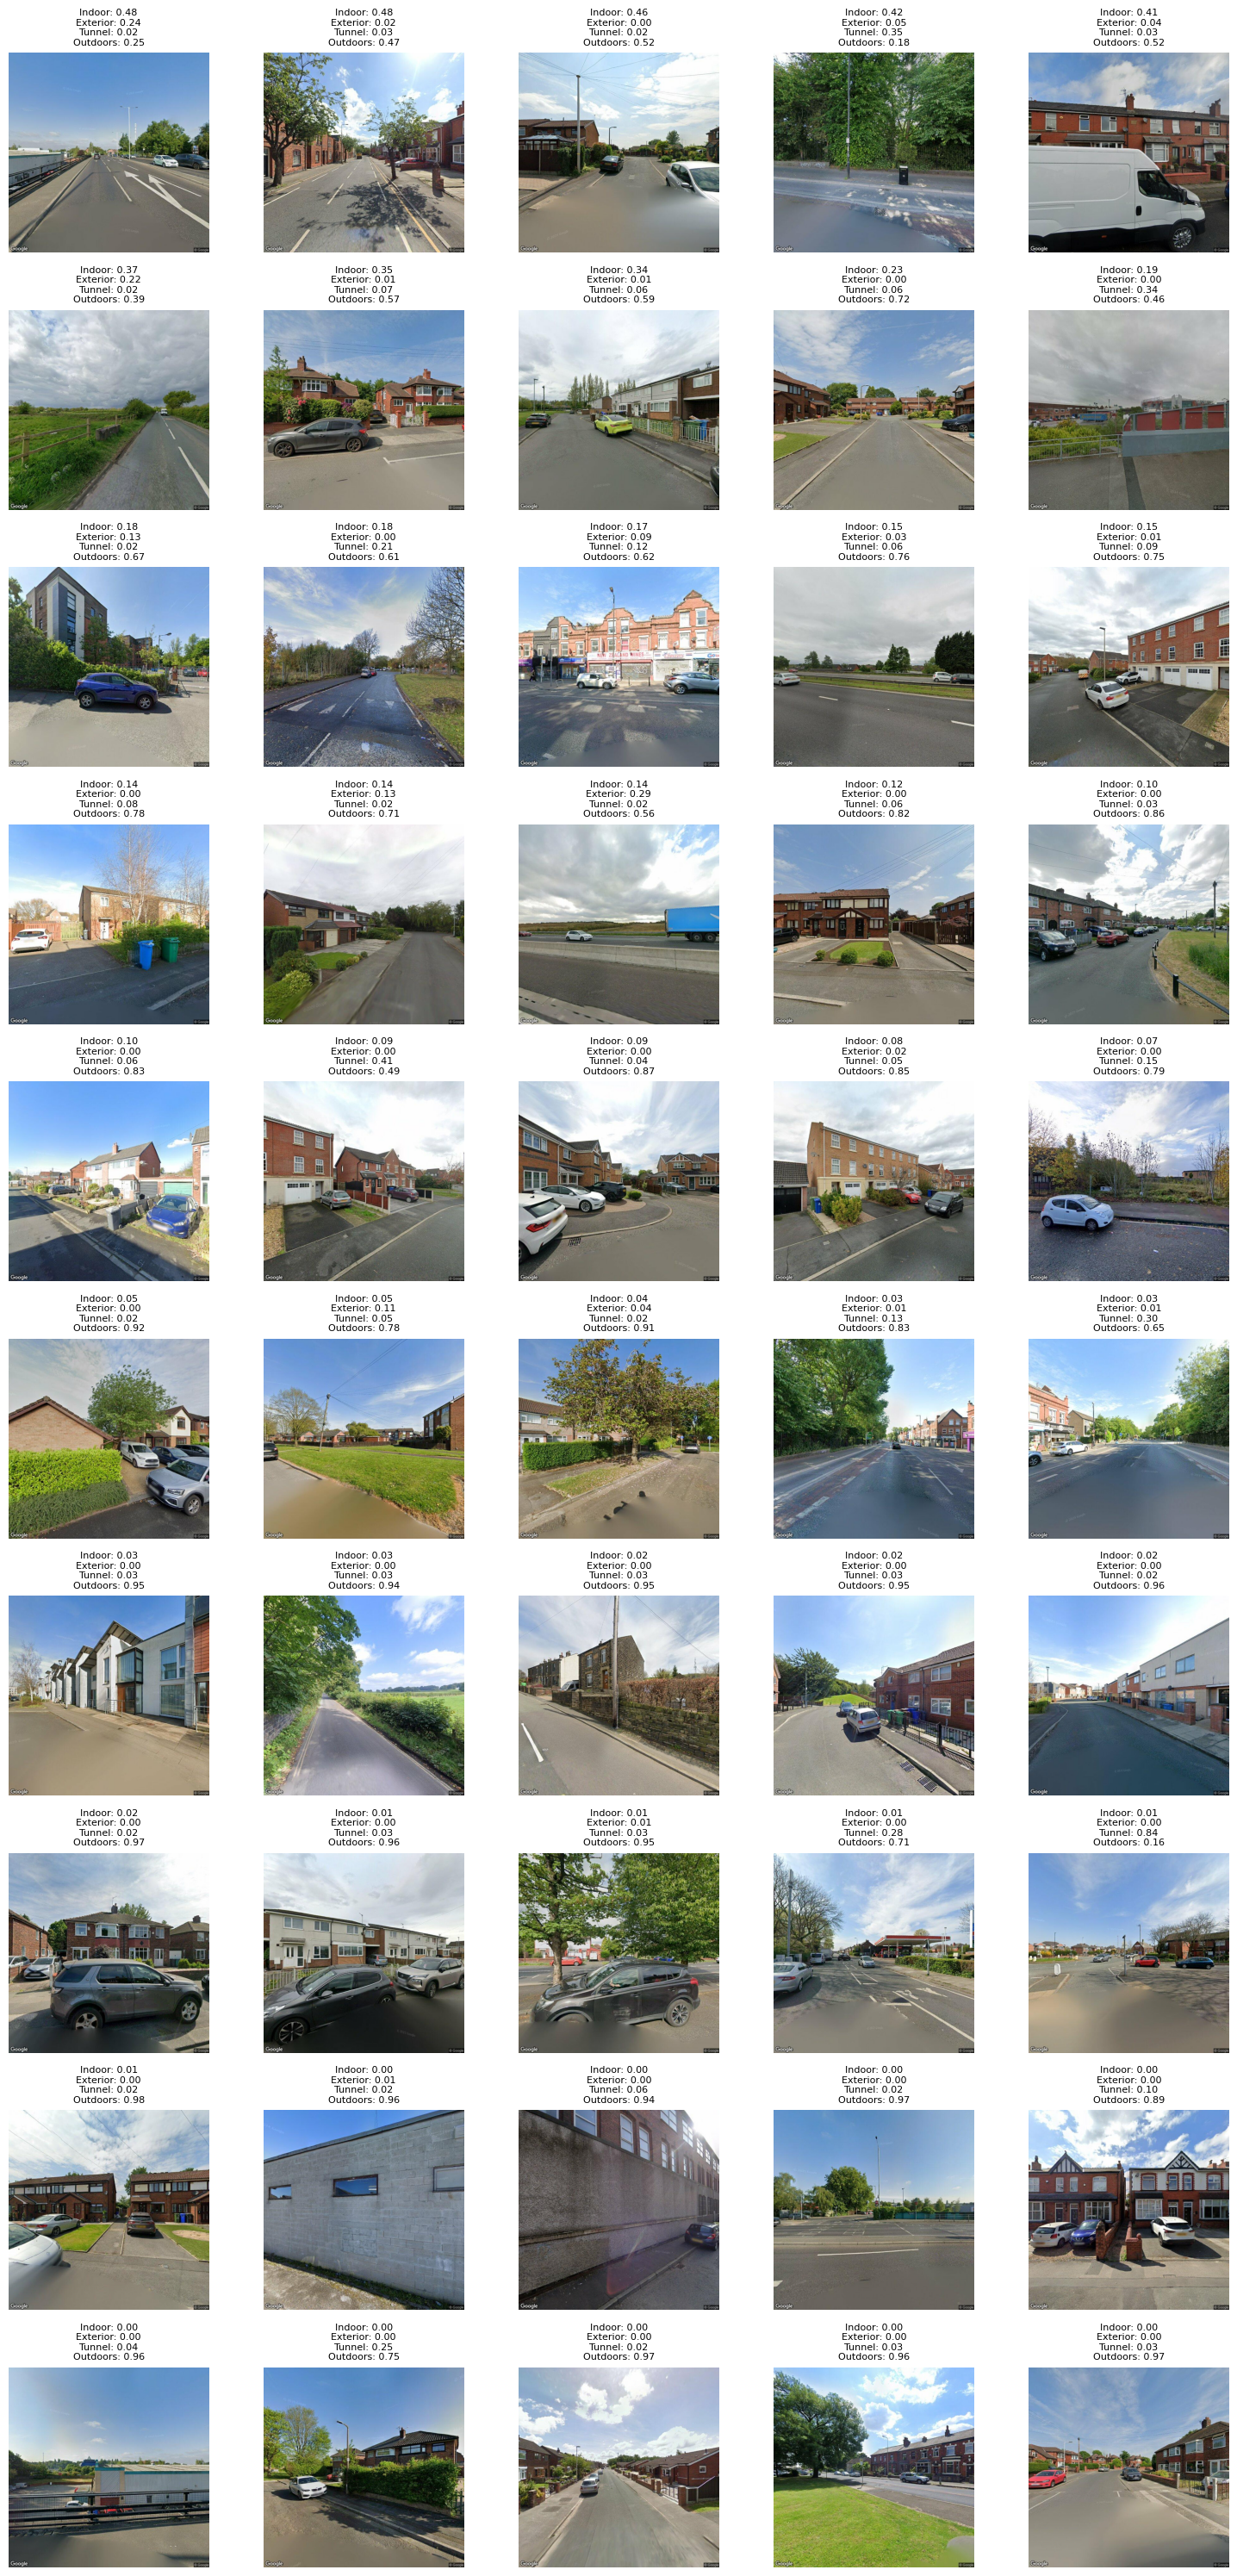

In [126]:
# ---- Example usage ----
plot_images_with_scores(sorted_paths[:50],      # top 20 images by indoor score
    category_probs[sorted_idx][:50], n_cols=5, sort_by="indoor")

In [26]:
model, preprocess = clip.load("ViT-B/32", device="cpu")
text = clip.tokenize(["a photo taken indoors", "a photo taken outdoors"])

inside_scores = []
image_paths_adj = []

for img_path in tqdm(expanded_gdf['image_files'], desc="Processing images"):
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")

    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0)
    except:
        continue

    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)

    inside_scores.append(float(sims[0,0]))
    image_paths_adj.append(adj_path)

# Sort
sorted_idx = np.argsort(inside_scores)[::-1]
sorted_scores = [inside_scores[i] for i in sorted_idx]
sorted_paths = [image_paths_adj[i] for i in sorted_idx]




Processing images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 75576/75576 [1:33:35<00:00, 13.46it/s]


In [100]:
model, preprocess = clip.load("ViT-B/32", device="cpu")
text = clip.tokenize(["a photo taken inside a building, room, or car", "a photo inside a tunnel",
                      "a photo of a building exterior", "a photo taken outdoors"])

inside_scores = []
image_paths_adj = []

for img_path in tqdm(sorted_paths[:100], desc="Processing images"):
    adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")

    try:
        image = preprocess(Image.open(adj_path)).unsqueeze(0)
    except:
        continue

    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(text)
        sims = (img_feat @ txt_feat.T).softmax(dim=-1)

    inside_scores.append(float(sims[0,0]))
    image_paths_adj.append(adj_path)

# Sort
sorted_idx_new = np.argsort(inside_scores)[::-1]
sorted_scores_new = [inside_scores[i] for i in sorted_idx_new]
sorted_paths_new = [image_paths_adj[i] for i in sorted_idx_new]

Processing images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


In [69]:
threshold = 0.2
num_over_threshold = sum(1 for s in inside_scores if s < threshold)
percentage = num_over_threshold / len(inside_scores) * 100

print(f"Images with inside_score > {threshold}: {num_over_threshold} "
      f"({percentage:.2f}% of all images)")


Images with inside_score > 0.2: 65248 (86.33% of all images)


In [36]:
expanded_gdf['inside_score'] = inside_scores

expanded_gdf_trimmed = expanded_gdf.copy()
expanded_gdf_trimmed = expanded_gdf_trimmed[expanded_gdf_trimmed['inside_score']<0.7]
expanded_gdf_trimmed['inside_score'].max()

In [14]:
X = all_embeddings

In [54]:
# from sklearn.neighbors import NearestNeighbors

# X=all_embeddings
# nbrs = NearestNeighbors(n_neighbors=10, metric="euclidean").fit(X)
# distances, _ = nbrs.kneighbors(X)

# knn_scores = distances[:, -1]  # distance to 10th neighbour

# outliers = np.argsort(knn_scores)[-500:]  # top 500 unusual images


In [55]:
# import math

# outliers = np.argsort(knn_scores)[-500:] 
# n_images = len(outliers)
# n_cols = 6
# n_rows = math.ceil(n_images / n_cols)

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, int(n_images/2)))
# axs = axs.flatten()

# for ax_num, idx in enumerate(outliers):
#     img_path = expanded_gdf['image_files'][idx]
#     adj_path = img_path.replace("airbnb-manchester/", "embeddings/").replace("../", "../../")
#     img = plt.imread(adj_path)
#     axs[ax_num].imshow(img)
#     axs[ax_num].axis("off")

# # hide unused axes
# for extra_ax in axs[n_images:]:
#     extra_ax.axis("off")


In [56]:
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=50,
#     min_samples=5,
#     metric='euclidean'
# ).fit(X)

# scores = clusterer.outlier_scores_  # higher = more outlier


## HDBSCAN

In [58]:
all_embeddings = np.stack(expanded_gdf['embeddings'].values)
len(all_embeddings)

75576